In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.linear_model import Lasso
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp
import os
import sys
import pysindy as ps

# Ignore matplotlib deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Seed the random number generators for reproducibility
np.random.seed(100)
sys.path.append('../')  
from test_data import experiment_data,add_noise,normalise_frobenius,normalise_minmax

# Function with non unqiue PDE: $u(t,x)=sin(x+t)$
We have here that $u$ solves the equations $u_t = u_x$ and $u_t= u_x+\lambda (u^2+u_x^2-1)$. Two things we can do here: show that the Jacobi criterion for analytic PDEs does not help and then apply the methods for polynomials to show non-uniqueness.  This time, we will add gaussian noise with standard deviation of $0.01u$.

### Create Data

In [2]:
experiment_name = 'analytic_nonunique_1'
n=200
u,x,t,formula = experiment_data(n_samples=n,experiment_name=experiment_name)
dx=x[1]-x[0]
dt=t[1]-t[0]
print(experiment_name)
print(formula)

analytic_nonunique_1
sin(t + x)


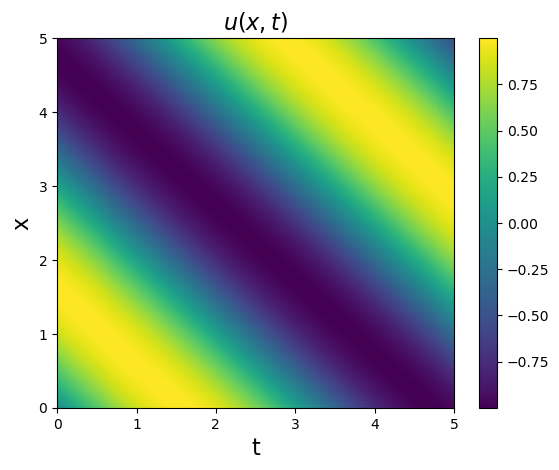

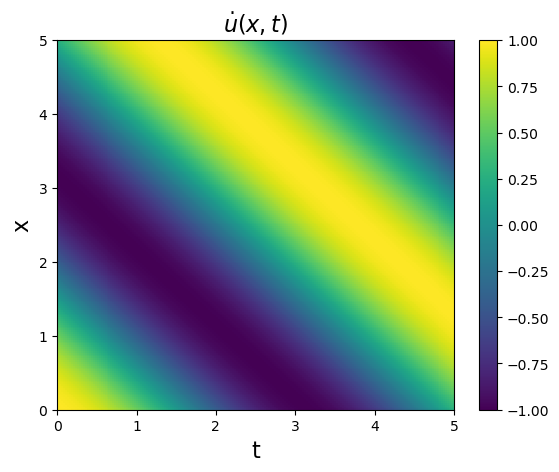

In [3]:
# Plot u and u_dot
plt.figure()
plt.pcolormesh(t, x, u)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$u(x, t)$', fontsize=16)
plt.colorbar()
plt.figure()

dt = t[1] - t[0]
u_dot = ps.FiniteDifference(axis=1)._differentiate(u, t=dt)

plt.pcolormesh(t, x, u_dot)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$\dot{u}(x, t)$', fontsize=16)

plt.colorbar()
plt.show()

## Check now numerically if this is the unique equation

We already know that the equation is not unique. First we want to show that the Jacobi criterion for analytic PDEs does not help, as it can only be used to show uniqueness and as $u$ is not algebraic we cannot use the other direction.
### Jacobi criterion

In [4]:
from numpy.linalg import matrix_rank, svd

In [5]:
from utils import plot_result_jacobi
def jacobi_criterion(u,space_range,time_range,fd_orders,target_noise=0,normalise=None):
    u_noise = add_noise(u,target_noise)
    fd_orders = [2, 7]
    sv_ratios = np.zeros([space_range, time_range])
    svs = np.zeros([2, space_range, time_range])
    for k, fd_order in enumerate(fd_orders):
        ut = ps.FiniteDifference(order=fd_order, d=1, axis=1, drop_endpoints=False)._differentiate(u_noise, t=dt)
        utx = ps.FiniteDifference(order=fd_order, d=1, axis=0, drop_endpoints=False)._differentiate(ut, dx)
        ux = ps.FiniteDifference(order=fd_order, d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
        uxx = ps.FiniteDifference(order=fd_order, d=2, axis=0, drop_endpoints=False)._differentiate(u_noise, dx) 
        for i in range(space_range):
            for j in range(time_range):
                x_i, t_j = i * 10 + 10, j * 10 + 10
                jacobian = np.array([[ut[x_i,t_j], ux[x_i,t_j]], [utx[x_i,t_j], uxx[x_i,t_j]]]).reshape(2,2)
                if normalise!=None:
                    jacobian=normalise(jacobian)
                sv = svd(jacobian, compute_uv=False)[-1]
                svs[k,i,j] = sv
    return svs

#### Jacobi Criterion: No noise

In [6]:
space_range = int(len(x)/10-1)
time_range = int(len(x)/10-1)
print((space_range,time_range))
fd_orders = [2, 7]
svs = jacobi_criterion(u,space_range,time_range,fd_orders)

(19, 19)


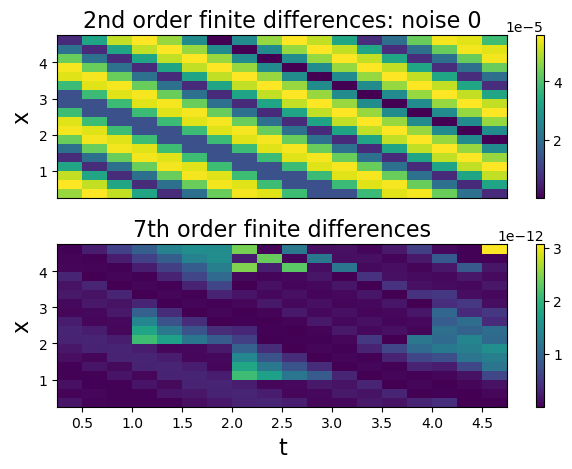

In [7]:
t_grid, x_grid = (np.arange(time_range) * 10 + 10) / len(t) * (t[len(t)-1] - t[0]) + t[0], (np.arange(space_range) * 10 + 10) / len(x) * (x[len(x)-1] - x[0]) + x[0]
plot_result_jacobi(svs,t_grid,x_grid,target_noise=0,fd_orders=fd_orders)

#### Jacobi Criterion: With noise

#### No normalisation

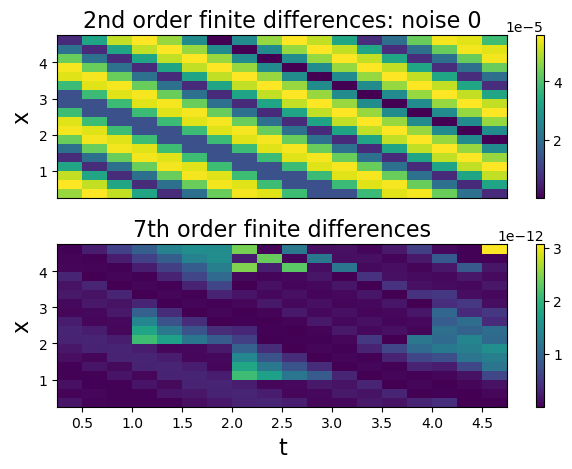

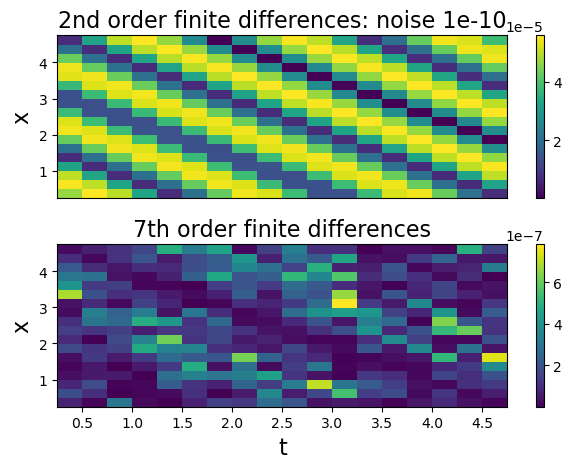

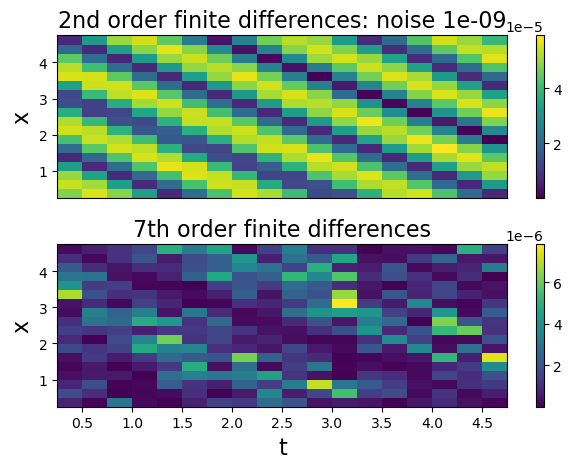

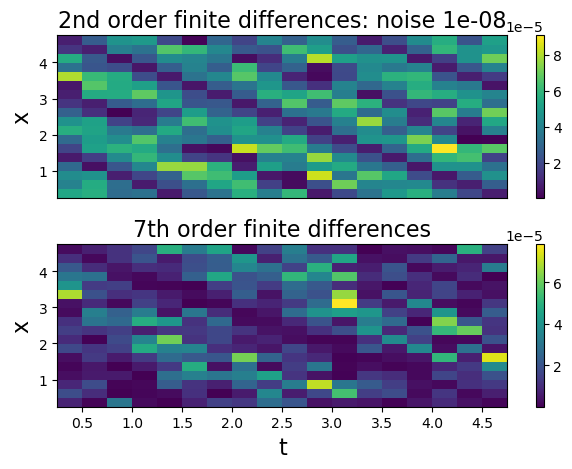

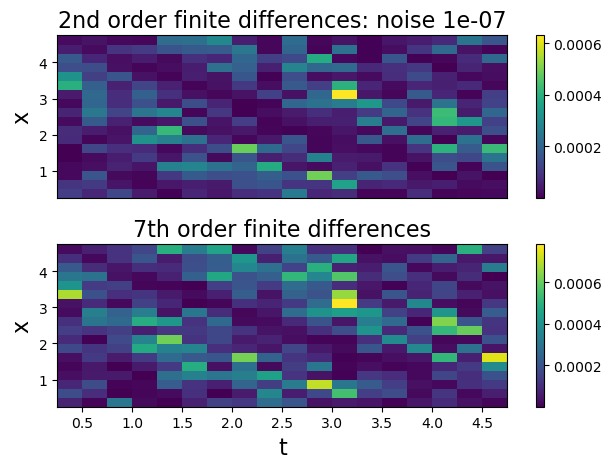

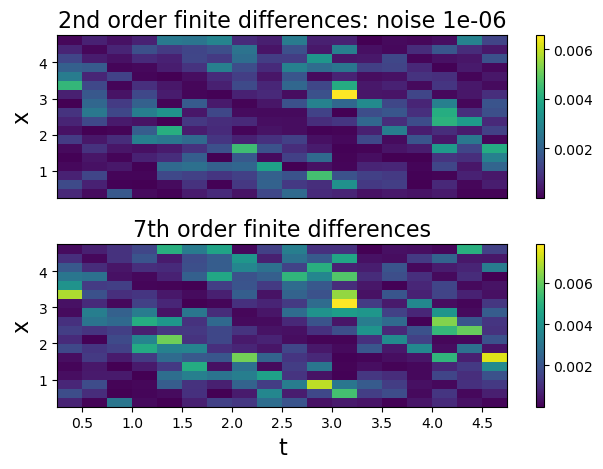

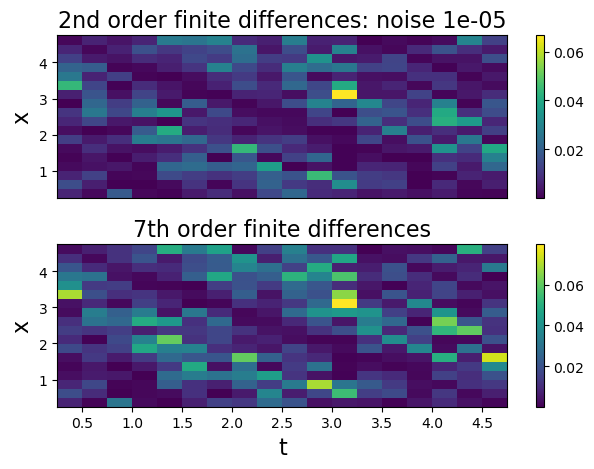

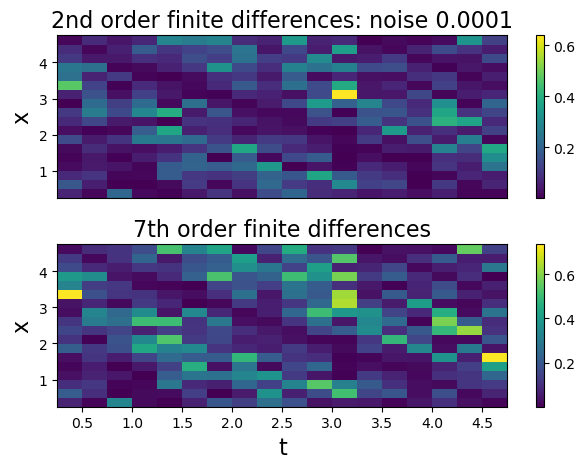

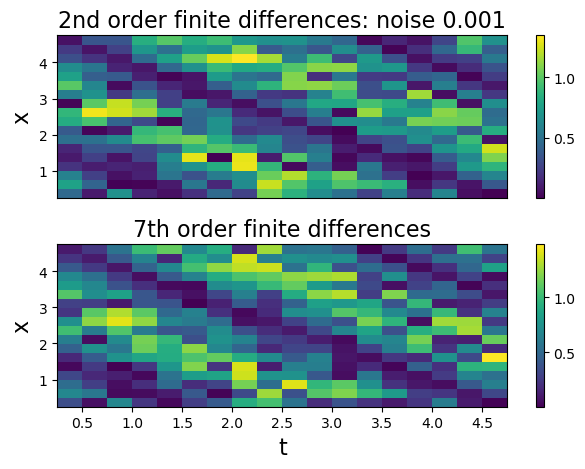

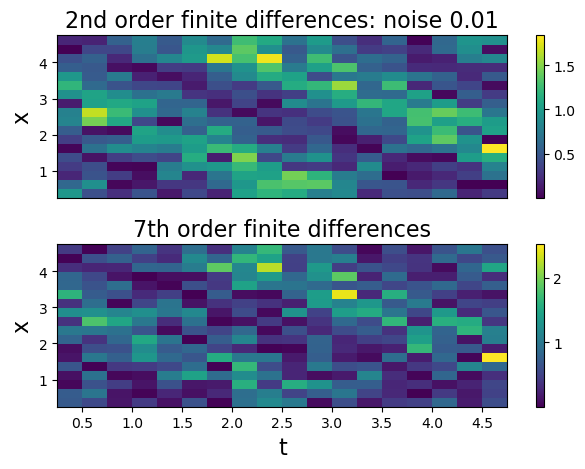

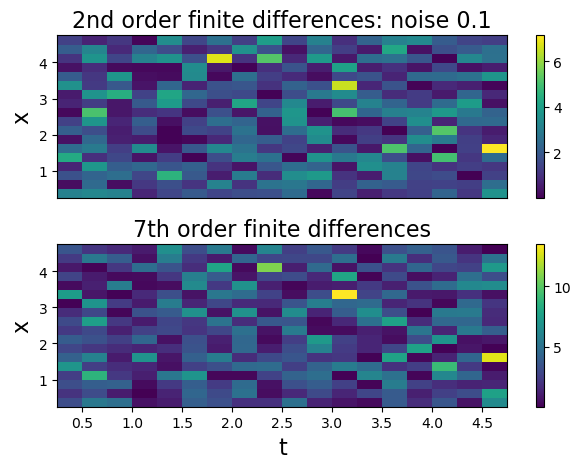

In [8]:
noise_levels = [0]+[10**(-10+i) for i in range(0,10)]
t_grid, x_grid = (np.arange(time_range) * 10 + 10) / len(t) * (t[len(t)-1] - t[0]) + t[0], (np.arange(space_range) * 10 + 10) / len(x) * (x[len(x)-1] - x[0]) + x[0]
space_range = int(len(x)/10-1)
time_range = int(len(x)/10-1)

for target_noise in noise_levels:
    svs = jacobi_criterion(u,space_range,time_range,fd_orders,target_noise)
    plot_result_jacobi(svs,t_grid,x_grid,target_noise=target_noise,fd_orders=fd_orders)

#### Frobenius normalisation

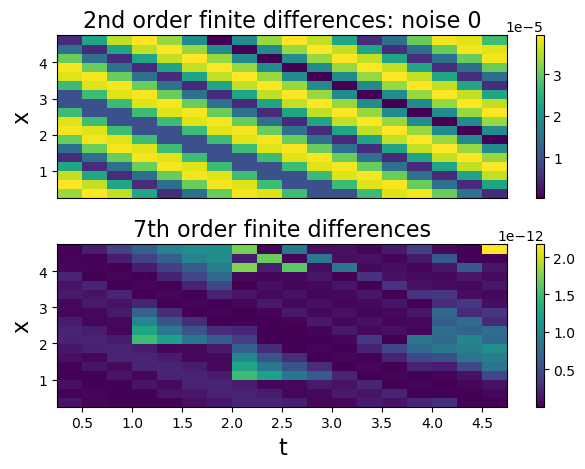

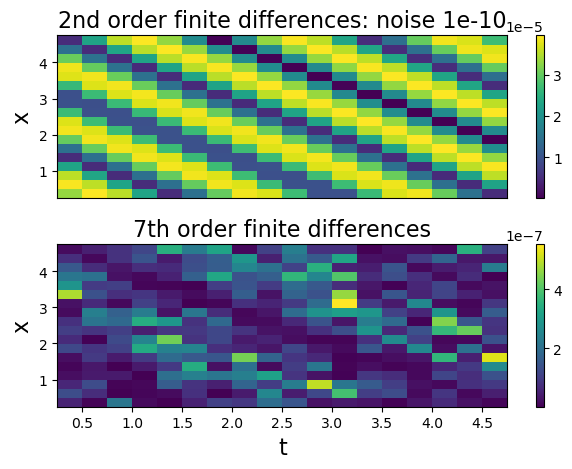

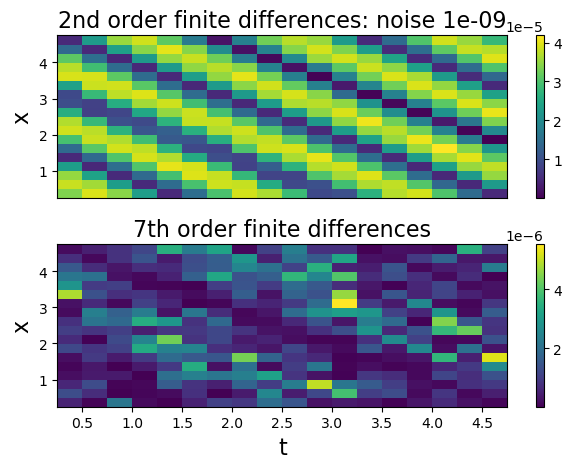

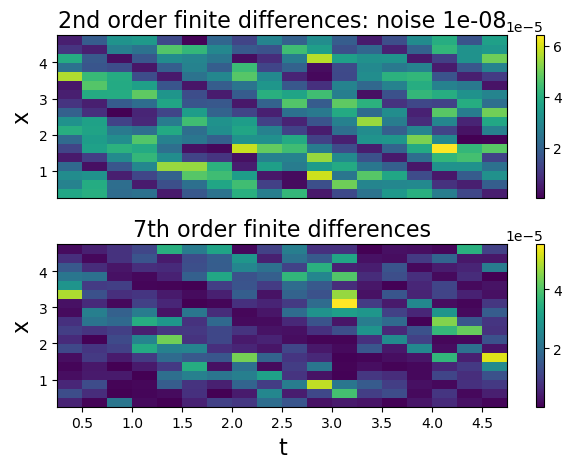

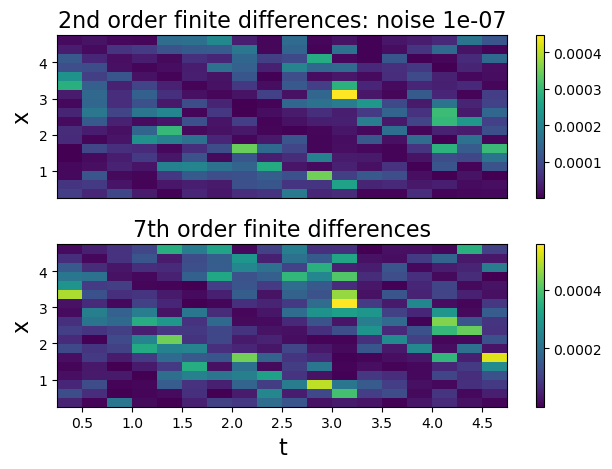

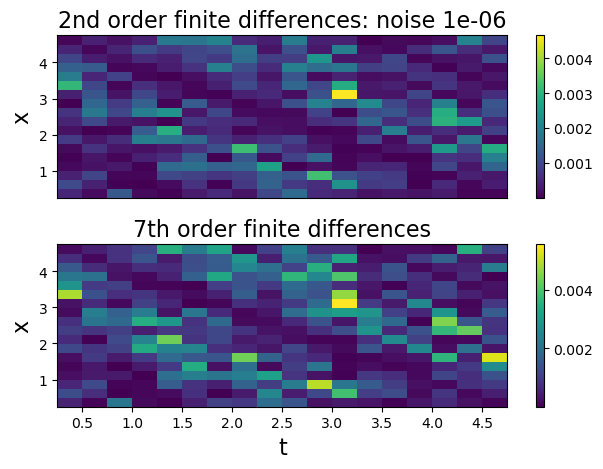

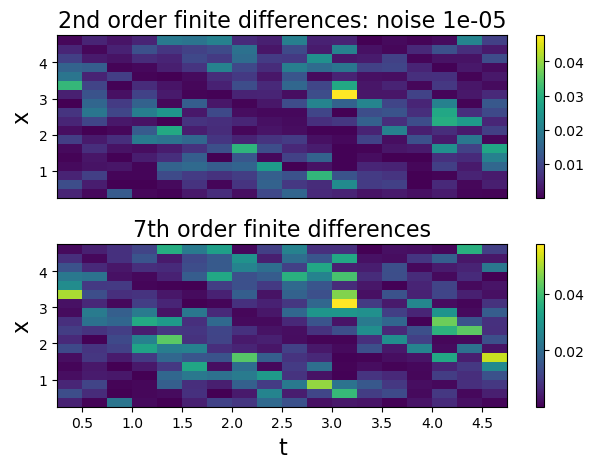

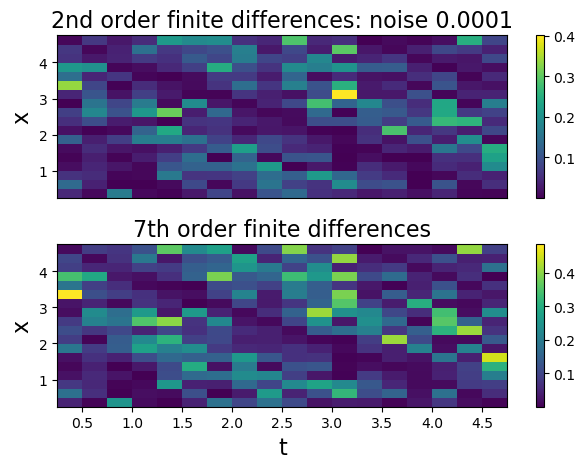

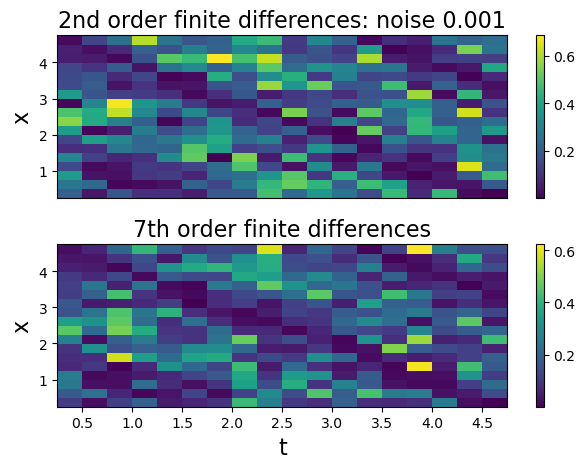

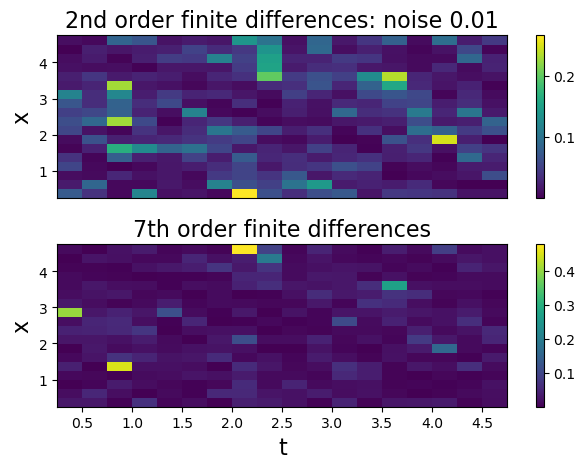

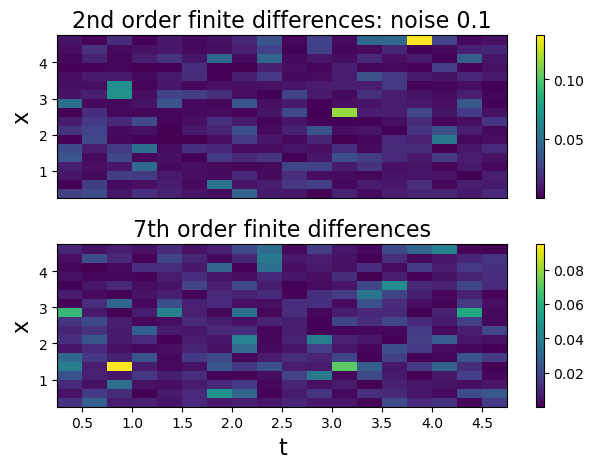

In [9]:
noise_levels = [0]+[10**(-10+i) for i in range(0,10)]
t_grid, x_grid = (np.arange(time_range) * 10 + 10) / len(t) * (t[len(t)-1] - t[0]) + t[0], (np.arange(space_range) * 10 + 10) / len(x) * (x[len(x)-1] - x[0]) + x[0]
space_range = int(len(x)/10-1)
time_range = int(len(x)/10-1)

for target_noise in noise_levels:
    svs = jacobi_criterion(u,space_range,time_range,fd_orders,target_noise,normalise=normalise_frobenius)
    plot_result_jacobi(svs,t_grid,x_grid,target_noise=target_noise,fd_orders=fd_orders)

#### Min max  normalisation

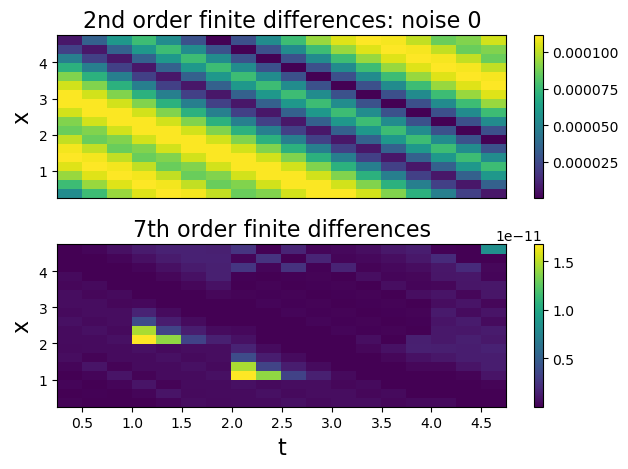

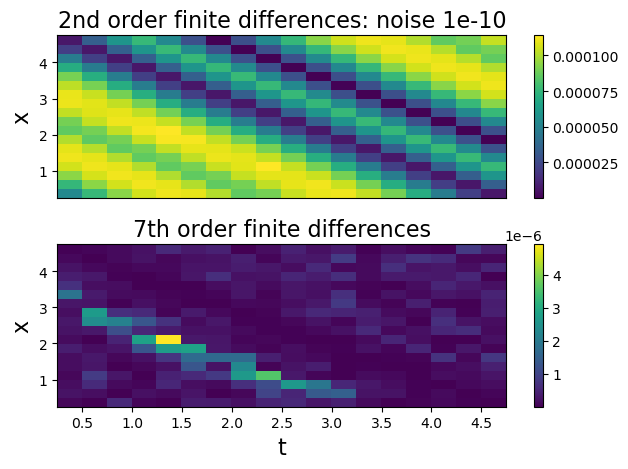

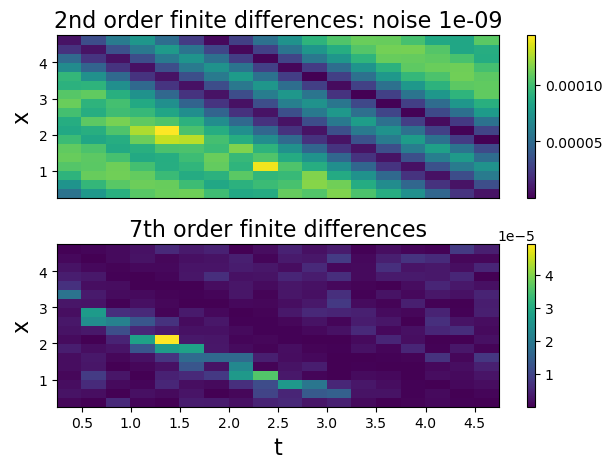

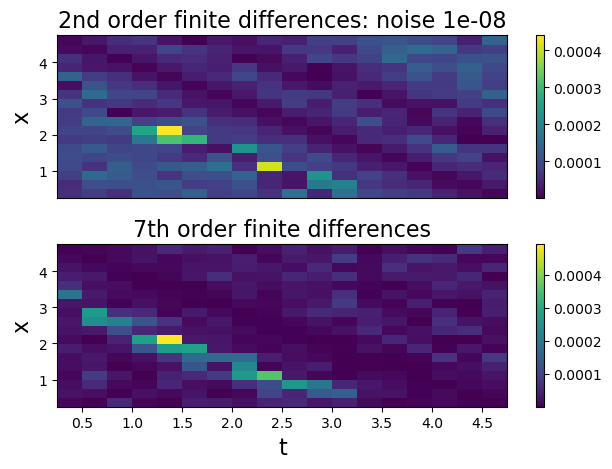

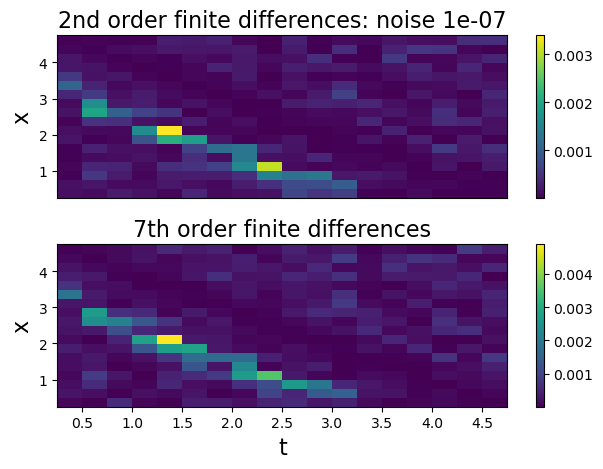

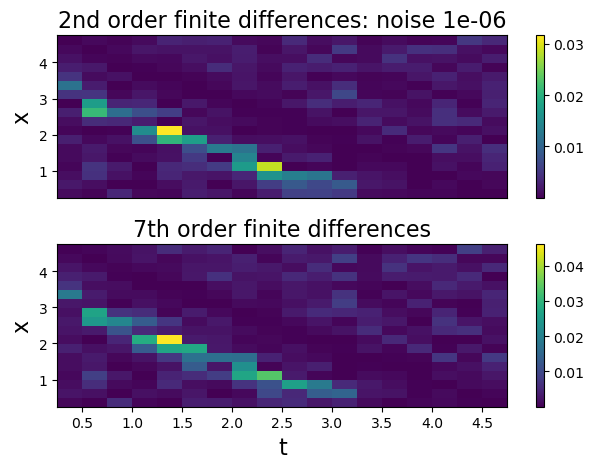

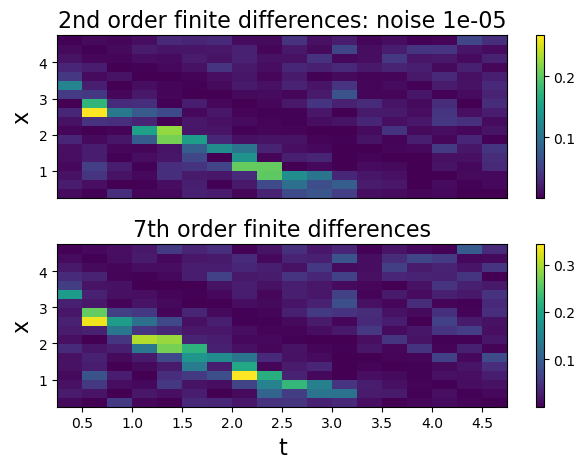

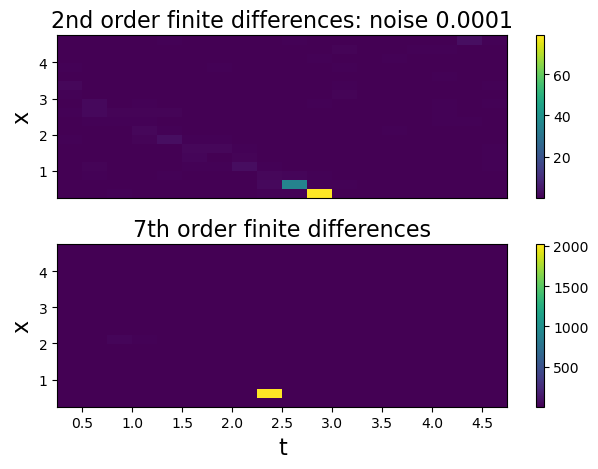

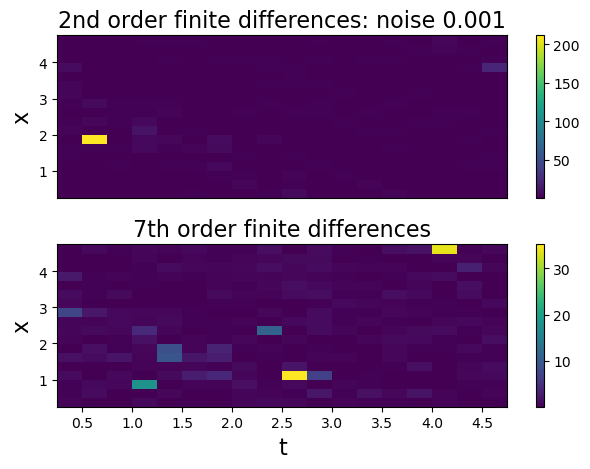

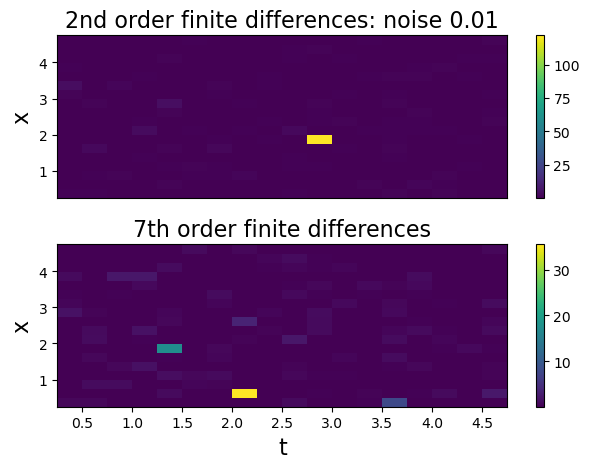

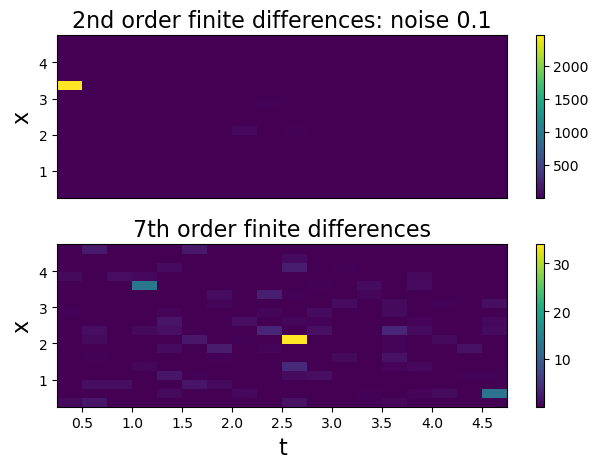

In [10]:
noise_levels = [0]+[10**(-10+i) for i in range(0,10)]
t_grid, x_grid = (np.arange(time_range) * 10 + 10) / len(t) * (t[len(t)-1] - t[0]) + t[0], (np.arange(space_range) * 10 + 10) / len(x) * (x[len(x)-1] - x[0]) + x[0]
space_range = int(len(x)/10-1)
time_range = int(len(x)/10-1)

for target_noise in noise_levels:
    svs = jacobi_criterion(u,space_range,time_range,fd_orders,target_noise,normalise=normalise_minmax)
    plot_result_jacobi(svs,t_grid,x_grid,target_noise=target_noise,fd_orders=fd_orders)

## Polynomial criterion
Let us validate now our believe that it is actually not the unique PDE by checking the condition of the feature matrix consisting out of $u$, $u_x$ and their derivatives.

In [11]:
from itertools import product
titlesize = 20
labelsize = titlesize - 2
tickssize = labelsize - 2

In [12]:
def monomials(features, order):
    multi_indices = []
    indices = np.arange(order + 1)
    number_features = features.shape[0]
    repeat_indices = [indices for i in range(number_features)]
    for i in product(*repeat_indices):
        if sum(i) <= order:
            multi_indices += [i]
    new_features = []
    for multi_index in multi_indices:
        new_feature = 1
        for i, j in enumerate(multi_index):
            new_feature *= features[i]**j
        new_features.append(new_feature.reshape(1,-1))
    return np.concatenate(new_features,axis=0)

def compute_distance_svs(u,dx,polynomial_order=2,fd_orders=range(2,8),normalise=None):
    distance_svs = []
    for fd_order in fd_orders:
        ux = ps.FiniteDifference(order=fd_order, d=1, axis=0,
                             drop_endpoints=False)._differentiate(u, dx)
        u_flat, u_x_flat = u.flatten(), ux.flatten()
        base_features = np.concatenate([u_flat.reshape(len(u_flat),-1), u_x_flat.reshape(len(u_flat),-1)], axis=1).T 
        library = monomials(base_features, order=polynomial_order)
        if normalise!=None:
            library = normalise(library)
        svs = svd(library, compute_uv=False)
        distance_svs.append(svs[-1])
    return distance_svs

#### Polynomial Criterion: No noise

In [13]:
fd_orders=list(range(2,8))
distance_svs = compute_distance_svs(u,dx,polynomial_order=2,fd_orders=fd_orders)

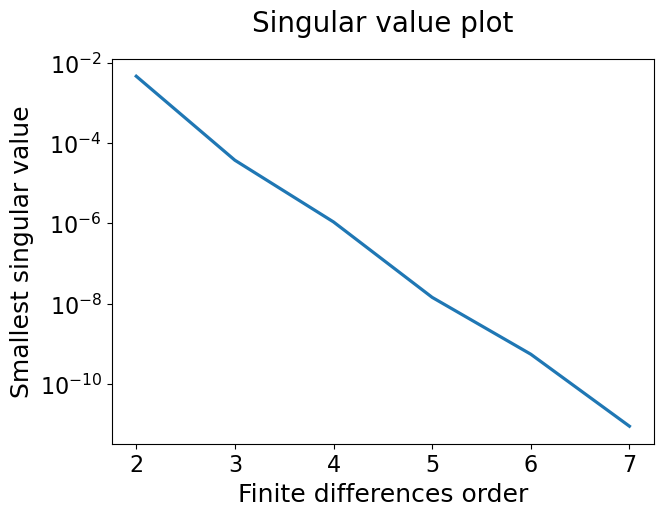

In [14]:
plt.figure(figsize=(7,5))
plt.plot(fd_orders, distance_svs, linewidth=2.3)
plt.title('Singular value plot', size=titlesize, y=1.05)
plt.xlabel('Finite differences order', size=labelsize)
plt.ylabel('Smallest singular value', size=labelsize)
# plt.ylim((10**(-7),10**2))
plt.xticks(fontsize=tickssize)
plt.yticks(fontsize=tickssize)
plt.yscale('log')

#### Polynomial Criterion: With noise

Noise level: 0
Distance SVS: [0.004578842537865715, 3.7081814581848574e-05, 1.077506739220738e-06, 1.4280904928931886e-08, 5.483525103114012e-10, 8.83438555992502e-12]
Distance SVS Frobenius normalisation: [1.3502498920406644e-05, 1.093450101066035e-07, 3.1772989283087004e-09, 4.211067316460532e-11, 1.6183064745334354e-12, 2.584698735768072e-14]
Distance SVS Minmax normalisation: [0.004576916498017372, 3.7081805723885234e-05, 1.077506739220738e-06, 1.4280904928931886e-08, 5.483926595142823e-10, 8.350228092732716e-12]
Noise level: 1e-10
Distance SVS: [0.004578846740910642, 3.707179740607571e-05, 1.1858974465778543e-06, 6.913961381870955e-07, 8.285980860116975e-07, 1.2049201856570265e-06]
Distance SVS Frobenius normalisation: [1.3502511313460371e-05, 1.0931547187857099e-07, 3.4969156618048304e-09, 2.0387544348680045e-09, 2.4433286841469385e-09, 3.5530088159319324e-09]
Distance SVS Minmax normalisation: [0.004576920608992746, 3.7071787196933565e-05, 1.1858974465778543e-06, 6.9139603390636

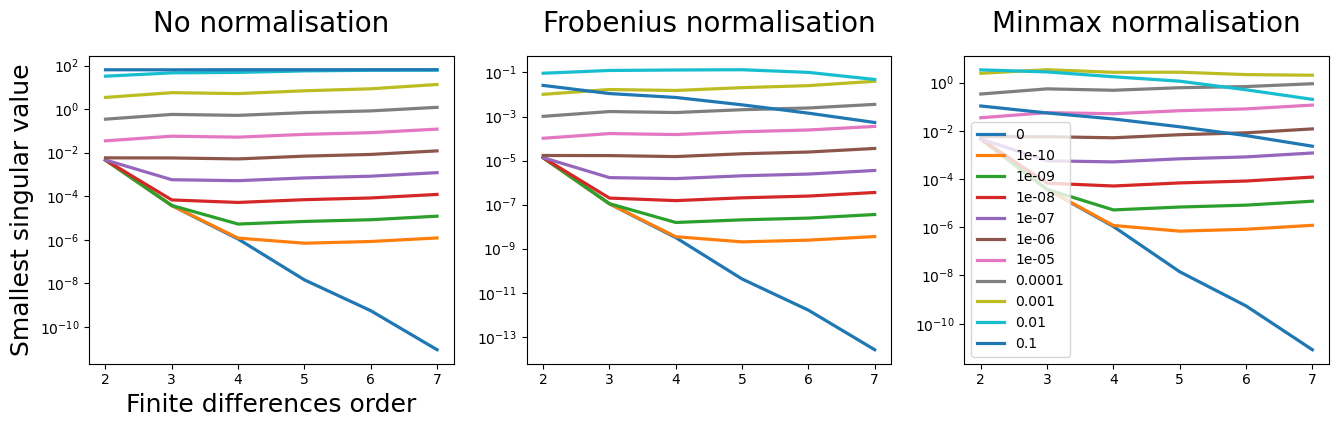

In [15]:
labelsize = titlesize - 2
noise_levels = [0]+[10**(-10+i) for i in range(0,10)]
titlesize = 20
labelsize = titlesize - 2
tickssize = labelsize - 2
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.title('No normalisation', size=titlesize, y=1.05)
plt.xlabel('Finite differences order', size=labelsize)
plt.ylabel('Smallest singular value', size=labelsize)
plt.yscale('log')
plt.subplot(1,3,2)
plt.title("Frobenius normalisation", size=titlesize, y=1.05)
plt.subplot(1,3,3)
plt.title("Minmax normalisation", size=titlesize, y=1.05)
for i,target_noise in enumerate(noise_levels):
    u_noise = add_noise(u,target_noise,seed=99)
    distance_svs = compute_distance_svs(u_noise,dx,fd_orders=fd_orders)
    distance_svs_frobenius = compute_distance_svs(u_noise,dx,fd_orders=fd_orders,normalise=normalise_frobenius)
    distance_svs_minmax = compute_distance_svs(u_noise,dx,fd_orders=fd_orders,normalise=normalise_minmax)
    print(f"Noise level: {target_noise}")
    print(f"Distance SVS: {distance_svs}")
    print(f"Distance SVS Frobenius normalisation: {distance_svs_frobenius}")
    print(f"Distance SVS Minmax normalisation: {distance_svs_minmax}")
    plt.subplot(1,3,1)
    plt.plot(range(2,8), distance_svs, linewidth=2.3,label=str(target_noise))
    plt.subplot(1,3,2)
    plt.plot(range(2,8), distance_svs_frobenius, linewidth=2.3,label=str(target_noise))
    plt.yscale('log')
    plt.subplot(1,3,3)
    plt.plot(range(2,8), distance_svs_minmax, linewidth=2.3,label=str(target_noise))
plt.yscale('log')
plt.legend()
plt.show()